# Product Amount Forecast by Time

## Data

Info about this data set: https://fred.stlouisfed.org/series/IPN31152N


Units:  Index 2012=100, Not Seasonally Adjusted

Frequency:  Monthly

The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

NAICS = 31152

Source Code: IP.N31152.N

Suggested Citation:
Board of Governors of the Federal Reserve System (US), Industrial Production: Nondurable Goods: Ice cream and frozen dessert [IPN31152N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IPN31152N, November 16, 2019.

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

plt.rcParams["figure.figsize"] = (10,6)

sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set it None to display all rows in the dataframe
# pd.set_option('display.max_rows', None)

# Set it to None to display all columns in the dataframe
pd.set_option('display.max_columns', None)

## Indest Data

In [3]:
df = pd.read_csv('Frozen_Dessert_Production.csv', 
                 index_col='DATE', 
                 parse_dates=True)

In [4]:
df.head()

,IPN31152N
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764


In [5]:
df = df.rename(columns={'IPN31152N' : 'Cold_Cycle'})

In [6]:
df

,Cold_Cycle
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764
...,...
2019-05-01,114.561
2019-06-01,124.960
2019-07-01,110.263


## Exploratory Data Analysis and Visualization

1. Implement basic steps to see how is your data looks like
2. Change the column name as "Production"
2. Plot your data and see its seasonalty

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 573 entries, 1972-01-01 to 2019-09-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Cold_Cycle  573 non-null    float64
dtypes: float64(1)
memory usage: 9.0 KB


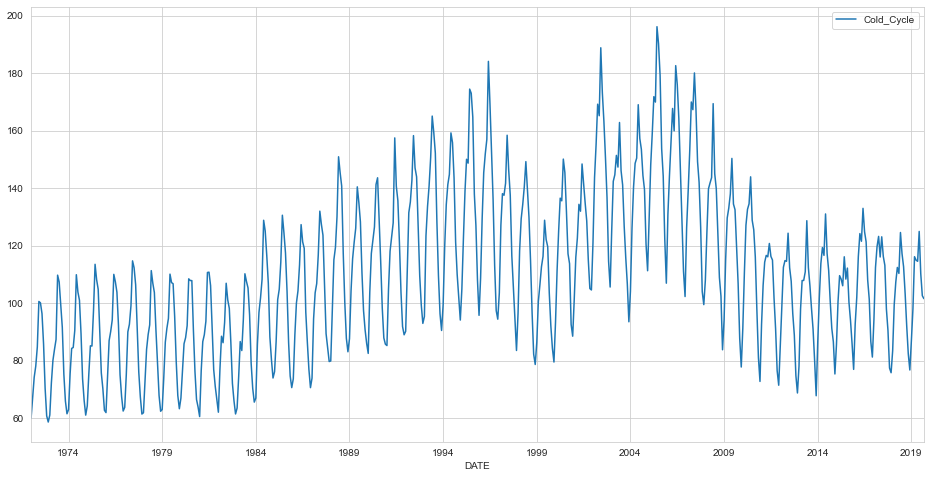

In [8]:
df.plot(figsize=(16,8));

## Preprocessing of Data

### Train Test Split

In [9]:
len(df)

573

In [10]:
test_size = 24

In [11]:
test_ind = len(df)- test_size
test_ind

549

In [12]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [13]:
train

,Cold_Cycle
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764
...,...
2017-05-01,116.064
2017-06-01,123.087
2017-07-01,116.264


In [14]:
test

,Cold_Cycle
DATE,
2017-10-01,90.473
2017-11-01,77.438
2017-12-01,75.812
2018-01-01,83.434
2018-02-01,99.490
2018-03-01,107.315
2018-04-01,112.431
2018-05-01,110.354
2018-06-01,124.584


### Scaling

In [15]:
from sklearn.preprocessing import MinMaxScaler

In [16]:
scaler = MinMaxScaler()

In [17]:
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## Time Series Generator

In [19]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [20]:
length = 12
batch_size = 1
generator = TimeseriesGenerator(train_scaled, train_scaled, length = length, batch_size = batch_size)

In [21]:
len(generator)

537

In [22]:
generator[0]

(array([[[0.00947104],
         [0.06108982],
         [0.11326273],
         [0.14145625],
         [0.18982663],
         [0.30495972],
         [0.30154406],
         [0.27416065],
         [0.19736841],
         [0.08532665],
         [0.01561588],
         [0.        ]]]),
 array([[0.01774221]]))

In [23]:
X, y = generator[0]

In [24]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.00947104 0.06108982 0.11326273 0.14145625 0.18982663 0.30495972
 0.30154406 0.27416065 0.19736841 0.08532665 0.01561588 0.        ]
Predict this y: 
 [[0.01774221]]


## Modelling & Model Performance

### Import related libraries

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

### Creating Model

### with "tanh" activation function

In [26]:
n_features = train_scaled.shape[1]

In [27]:
model = Sequential()
model.add(LSTM(128, activation = 'tanh', return_sequences=True, input_shape = (length, n_features)))
model.add(LSTM(64, activation = 'tanh'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 128)           66560     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 116,033
Trainable params: 116,033
Non-trainable params: 0
_________________________________________________________________


In [29]:
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = batch_size)

In [30]:
len(validation_generator)

12

In [39]:
model.fit_generator(generator,
                    epochs = 20,
                    validation_data = validation_generator
                   )

Epoch 1/20
537/537 [==============================] - 7s 14ms/step - loss: 0.0024 - val_loss: 0.0019
Epoch 2/20
537/537 [==============================] - 8s 14ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 3/20
537/537 [==============================] - 6s 11ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 4/20
537/537 [==============================] - 7s 12ms/step - loss: 0.0021 - val_loss: 0.0016
Epoch 5/20
537/537 [==============================] - 9s 18ms/step - loss: 0.0025 - val_loss: 0.0018
Epoch 6/20
537/537 [==============================] - 10s 18ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 7/20
537/537 [==============================] - 8s 14ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 8/20
537/537 [==============================] - 8s 14ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 9/20
537/537 [==============================] - 9s 17ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 10/20
537/537 [==============================] - 9s 17ms/step - loss: 0.0020 - val_l

<AxesSubplot:>

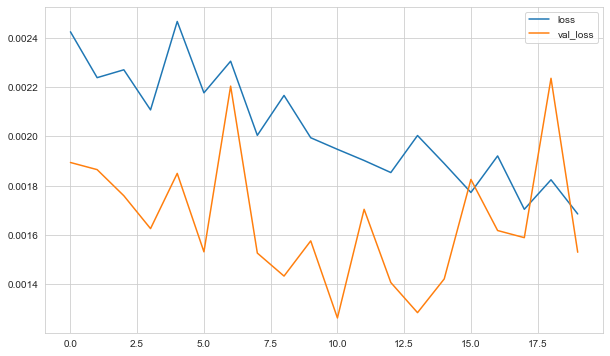

In [40]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

### Evaluate on Test Data

In [41]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [42]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\nmae:", mae, "\nmse:",mse, "\nrmse:",rmse)

In [43]:
predictions_scaled = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))    

for i in range(length):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)
    
    # store prediction
    predictions_scaled.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis=1)

In [44]:
predictions_scaled

[array([0.23583448], dtype=float32),
 array([0.216277], dtype=float32),
 array([0.23202623], dtype=float32),
 array([0.33303466], dtype=float32),
 array([0.43520665], dtype=float32),
 array([0.48953414], dtype=float32),
 array([0.51741606], dtype=float32),
 array([0.5777232], dtype=float32),
 array([0.5634056], dtype=float32),
 array([0.516152], dtype=float32),
 array([0.44272023], dtype=float32),
 array([0.36331138], dtype=float32)]

In [45]:
eval_metrics(test_scaled[:length], predictions_scaled)

r2_score: -0.03369274281285084 
mae: 0.10078160072802572 
mse: 0.01289080881921712 
rmse: 0.11353769778895959


with EarlyStop

In [46]:
from tensorflow.keras.callbacks import EarlyStopping

In [47]:
model_early = Sequential()
model_early.add(LSTM(100, activation = 'tanh', return_sequences=True, input_shape = (length, n_features)))
model_early.add(LSTM(50, activation = 'tanh'))
model_early.add(Dense(1))
model_early.compile(optimizer = 'adam', loss = 'mse')

In [48]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

In [49]:
model_early.fit_generator(generator,
                    epochs = 20,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/20
537/537 [==============================] - 11s 13ms/step - loss: 0.0230 - val_loss: 0.0023
Epoch 2/20
537/537 [==============================] - 6s 12ms/step - loss: 0.0048 - val_loss: 0.0020
Epoch 3/20
537/537 [==============================] - 6s 11ms/step - loss: 0.0048 - val_loss: 0.0030
Epoch 4/20
537/537 [==============================] - 7s 13ms/step - loss: 0.0042 - val_loss: 0.0067
Epoch 5/20
537/537 [==============================] - 7s 14ms/step - loss: 0.0039 - val_loss: 0.0027
Epoch 6/20
537/537 [==============================] - 8s 14ms/step - loss: 0.0039 - val_loss: 0.0018
Epoch 7/20
537/537 [==============================] - 6s 11ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 8/20
537/537 [==============================] - 7s 14ms/step - loss: 0.0037 - val_loss: 0.0024
Epoch 9/20
537/537 [==============================] - 9s 17ms/step - loss: 0.0033 - val_loss: 0.0029
Epoch 10/20
537/537 [==============================] - 8s 16ms/step - loss: 0.0030 - val_l

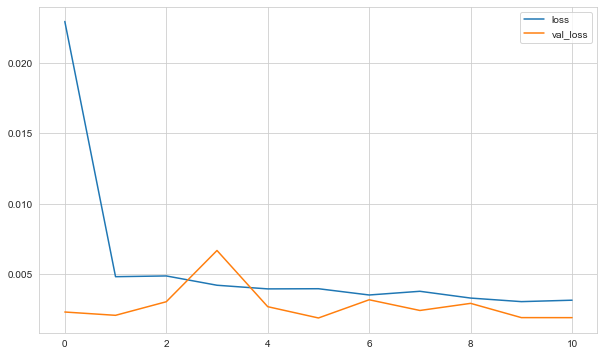

In [50]:
loss_df = pd.DataFrame(model_early.history.history)
loss_df.plot();

#### Evaluate on Test Data

In [51]:
predictions_scaled = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))    

for i in range(length):
    
    # get prediction 1 time stamp ahead
    current_pred = model_early.predict(current_batch)
    
    # store prediction
    predictions_scaled.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis=1)

In [52]:
predictions_scaled

[array([0.23970507], dtype=float32),
 array([0.22197396], dtype=float32),
 array([0.24905397], dtype=float32),
 array([0.30137458], dtype=float32),
 array([0.35693082], dtype=float32),
 array([0.4035113], dtype=float32),
 array([0.43572733], dtype=float32),
 array([0.4474996], dtype=float32),
 array([0.43638885], dtype=float32),
 array([0.39449066], dtype=float32),
 array([0.3337225], dtype=float32),
 array([0.27034426], dtype=float32)]

In [53]:
eval_metrics(test_scaled[:length], predictions_scaled)

r2_score: 0.5991201918041531 
mae: 0.06276222671556175 
mse: 0.004999227287670618 
rmse: 0.07070521400625712


#### Inverse Transformations and Comparing

In [54]:
predictions = scaler.inverse_transform(predictions_scaled)

In [55]:
compare = test[:12]

In [56]:
compare['Predictions'] = predictions

In [57]:
compare

,Cold_Cycle,Predictions
DATE,,
2017-10-01,90.473,91.623
2017-11-01,77.438,89.184
2017-12-01,75.812,92.908
2018-01-01,83.434,100.103
2018-02-01,99.490,107.743
2018-03-01,107.315,114.148
2018-04-01,112.431,118.578
2018-05-01,110.354,120.197
2018-06-01,124.584,118.669


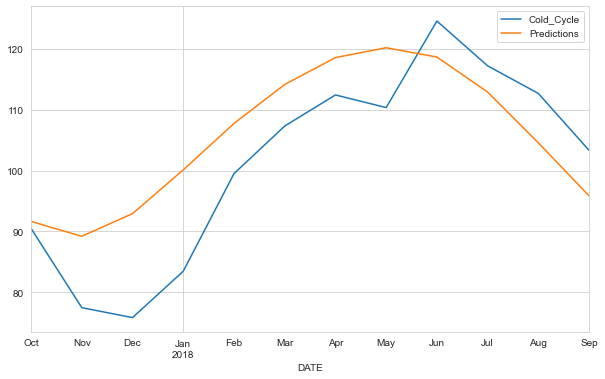

In [58]:
compare.plot();

#### Calculation R2 Score and Error Metrics

In [60]:
eval_metrics(compare.Cold_Cycle, compare.Predictions)

r2_score: 0.5991201918041535 
mae: 8.630678568341084 
mse: 94.53575141973037 
rmse: 9.722949728335037


### with "relu" activation function

In [61]:
model = Sequential()
model.add(LSTM(128, activation = 'relu', return_sequences=True, input_shape = (length, n_features)))
model.add(LSTM(64, activation = 'relu'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [62]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 12, 128)           66560     
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 116,033
Trainable params: 116,033
Non-trainable params: 0
_________________________________________________________________


In [63]:
model.fit_generator(generator,
                    epochs = 20,
                    validation_data = validation_generator
                    )

Epoch 1/20
537/537 [==============================] - 9s 12ms/step - loss: 0.0287 - val_loss: 0.0035
Epoch 2/20
537/537 [==============================] - 6s 12ms/step - loss: 0.0107 - val_loss: 0.0018
Epoch 3/20
537/537 [==============================] - 7s 13ms/step - loss: 0.0065 - val_loss: 0.0036
Epoch 4/20
537/537 [==============================] - 6s 12ms/step - loss: 0.0057 - val_loss: 0.0054
Epoch 5/20
537/537 [==============================] - 6s 12ms/step - loss: 0.0062 - val_loss: 0.0020
Epoch 6/20
537/537 [==============================] - 6s 12ms/step - loss: 0.0053 - val_loss: 0.0016
Epoch 7/20
537/537 [==============================] - 6s 12ms/step - loss: 0.0049 - val_loss: 0.0018
Epoch 8/20
537/537 [==============================] - 6s 12ms/step - loss: 0.0045 - val_loss: 0.0037
Epoch 9/20
537/537 [==============================] - 6s 12ms/step - loss: 0.0040 - val_loss: 0.0042
Epoch 10/20
537/537 [==============================] - 11s 21ms/step - loss: 0.0034 - val_l

<AxesSubplot:>

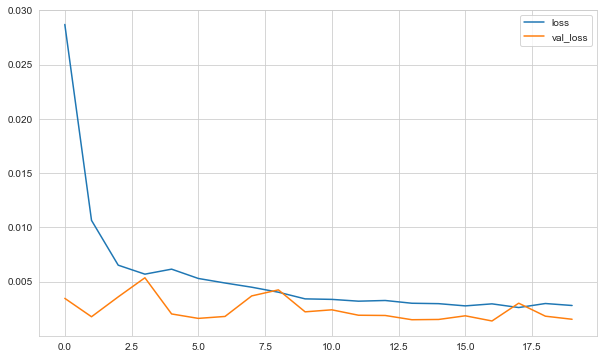

In [64]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

#### Evaluate on Test Data

In [65]:
predictions_scaled = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))    

for i in range(length):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)
    
    # store prediction
    predictions_scaled.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis=1)

In [66]:
predictions_scaled

[array([0.23529062], dtype=float32),
 array([0.18118897], dtype=float32),
 array([0.1794166], dtype=float32),
 array([0.26940233], dtype=float32),
 array([0.3453591], dtype=float32),
 array([0.40398198], dtype=float32),
 array([0.4434503], dtype=float32),
 array([0.46721548], dtype=float32),
 array([0.4696709], dtype=float32),
 array([0.4298457], dtype=float32),
 array([0.353423], dtype=float32),
 array([0.2643628], dtype=float32)]

In [67]:
eval_metrics(test_scaled[:length], predictions_scaled)

r2_score: 0.771377454526631 
mae: 0.04569085610906431 
mse: 0.0028510691846789405 
rmse: 0.05339540415315667


with EarlyStop

In [68]:
model_early2 = Sequential()
model_early2.add(LSTM(100, activation = 'relu', return_sequences=True, input_shape = (length, n_features)))
model_early2.add(LSTM(50, activation = 'relu'))
model_early2.add(Dense(1))
model_early2.compile(optimizer = 'adam', loss = 'mse')

In [69]:
model_early2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 12, 100)           40800     
                                                                 
 lstm_7 (LSTM)               (None, 50)                30200     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


In [70]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5,restore_best_weights = True)

In [71]:
model_early2.fit_generator(generator,
                    epochs = 20,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/20
537/537 [==============================] - 7s 8ms/step - loss: 0.0291 - val_loss: 0.0050
Epoch 2/20
537/537 [==============================] - 4s 7ms/step - loss: 0.0124 - val_loss: 0.0022
Epoch 3/20
537/537 [==============================] - 4s 8ms/step - loss: 0.0074 - val_loss: 0.0020
Epoch 4/20
537/537 [==============================] - 4s 8ms/step - loss: 0.0064 - val_loss: 0.0021
Epoch 5/20
537/537 [==============================] - 3s 6ms/step - loss: 0.0062 - val_loss: 0.0061
Epoch 6/20
537/537 [==============================] - 4s 7ms/step - loss: 0.0053 - val_loss: 0.0017
Epoch 7/20
537/537 [==============================] - 4s 8ms/step - loss: 0.0054 - val_loss: 0.0032
Epoch 8/20
537/537 [==============================] - 3s 6ms/step - loss: 0.0051 - val_loss: 0.0015
Epoch 9/20
537/537 [==============================] - 3s 5ms/step - loss: 0.0041 - val_loss: 0.0021
Epoch 10/20
537/537 [==============================] - 3s 5ms/step - loss: 0.0037 - val_loss: 0.0038

<AxesSubplot:>

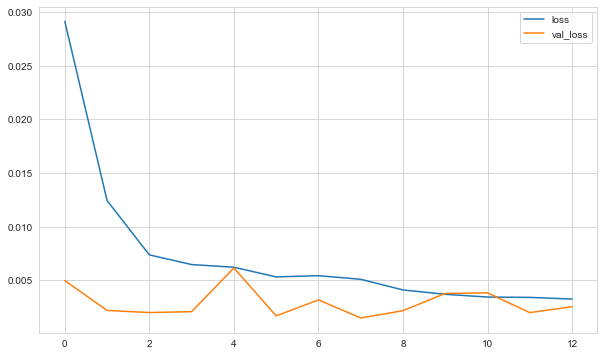

In [72]:
loss_df = pd.DataFrame(model_early2.history.history)
loss_df.plot()

Evaluate on Test Data

In [73]:
predictions_scaled = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))    

for i in range(length):
    
    # get prediction 1 time stamp ahead
    current_pred = model_early2.predict(current_batch)
    
    # store prediction
    predictions_scaled.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis=1)

In [74]:
predictions_scaled

[array([0.28548273], dtype=float32),
 array([0.24823382], dtype=float32),
 array([0.26132593], dtype=float32),
 array([0.3498746], dtype=float32),
 array([0.4495897], dtype=float32),
 array([0.5144473], dtype=float32),
 array([0.55626863], dtype=float32),
 array([0.5692008], dtype=float32),
 array([0.5619084], dtype=float32),
 array([0.5058493], dtype=float32),
 array([0.43322533], dtype=float32),
 array([0.3410677], dtype=float32)]

In [75]:
eval_metrics(test_scaled[:length], predictions_scaled)

r2_score: -0.28129782275401327 
mae: 0.113600984021416 
mse: 0.01597860233463157 
rmse: 0.1264064964099218


#### Inverse Transformations and Comparing

In [76]:
predictions = scaler.inverse_transform(predictions_scaled)

In [77]:
compare = test[:12]

In [78]:
compare['Predictions'] = predictions

In [79]:
compare

,Cold_Cycle,Predictions
DATE,,
2017-10-01,90.473,97.918
2017-11-01,77.438,92.795
2017-12-01,75.812,94.596
2018-01-01,83.434,106.772
2018-02-01,99.490,120.485
2018-03-01,107.315,129.403
2018-04-01,112.431,135.154
2018-05-01,110.354,136.933
2018-06-01,124.584,135.930


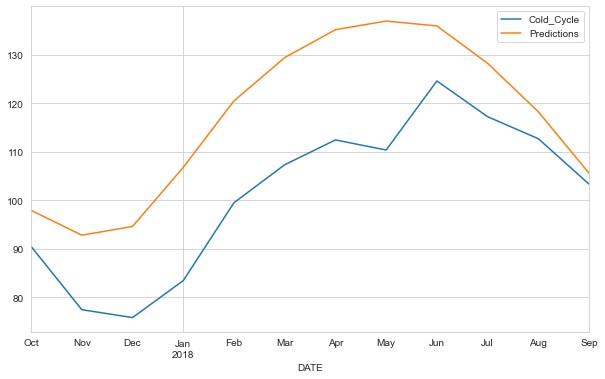

In [80]:
compare.plot();

#### Calculation R2 Score and Error Metrics

In [82]:
eval_metrics(compare.Cold_Cycle, compare.Predictions)

r2_score: -0.28129782275401216 
mae: 15.62171435662259 
mse: 302.15653168377776 
rmse: 17.38265030666434


## Retrain and Forecasting

Select activation function providing a better score, create your final model with full data, forecast for the next 12 months, and plot this forecast.

In [83]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [84]:
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length = length, batch_size = batch_size)

In [85]:
len(df)

573

In [86]:
len(generator)

561

In [100]:
model = Sequential()
model.add(LSTM(128, activation = 'relu', return_sequences=True, input_shape = (length, n_features)))
model.add(LSTM(64, activation = 'relu'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

model.fit_generator(generator, epochs=14)

Epoch 1/14
561/561 [==============================] - 8s 11ms/step - loss: 0.0297
Epoch 2/14
561/561 [==============================] - 6s 11ms/step - loss: 0.0094
Epoch 3/14
561/561 [==============================] - 8s 14ms/step - loss: 0.0067
Epoch 4/14
561/561 [==============================] - 6s 10ms/step - loss: 0.0103
Epoch 5/14
561/561 [==============================] - 6s 10ms/step - loss: 0.0062
Epoch 6/14
561/561 [==============================] - 6s 11ms/step - loss: 0.0056
Epoch 7/14
561/561 [==============================] - 6s 10ms/step - loss: 0.0052
Epoch 8/14
561/561 [==============================] - 7s 12ms/step - loss: 0.0046
Epoch 9/14
561/561 [==============================] - 7s 12ms/step - loss: 0.0043
Epoch 10/14
561/561 [==============================] - 8s 14ms/step - loss: 0.0043
Epoch 11/14
561/561 [==============================] - 7s 12ms/step - loss: 0.0036
Epoch 12/14
561/561 [==============================] - 5s 10ms/step - loss: 0.0032
Epoch 13/14
5

In [101]:
scaled_full_data.shape

(573, 1)

In [102]:
scaled_full_data[-length:].shape

(12, 1)

In [103]:
forecast = []
# Replace periods with whatever forecast length you want

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)
    
    # store prediction
    forecast.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis = 1)

In [104]:
forecast = scaler.inverse_transform(forecast)

In [105]:
forecast

array([[ 90.67882767],
       [ 84.39053495],
       [ 82.87515366],
       [ 89.12928965],
       [ 99.3456532 ],
       [108.11545914],
       [112.35227039],
       [115.89358271],
       [115.68697027],
       [109.86456474],
       [103.50263086],
       [ 97.45286762]])

In [106]:
df

,Cold_Cycle
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764
...,...
2019-05-01,114.561
2019-06-01,124.960
2019-07-01,110.263


In [107]:
forecast_index = pd.date_range(start = '2019-10-01', periods = length, freq = 'MS')

In [108]:
forecast_index

DatetimeIndex(['2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01',
               '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01'],
              dtype='datetime64[ns]', freq='MS')

In [109]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['Forecast'])

In [110]:
forecast_df

,Forecast
2019-10-01,90.679
2019-11-01,84.391
2019-12-01,82.875
2020-01-01,89.129
2020-02-01,99.346
2020-03-01,108.115
2020-04-01,112.352
2020-05-01,115.894
2020-06-01,115.687
2020-07-01,109.865


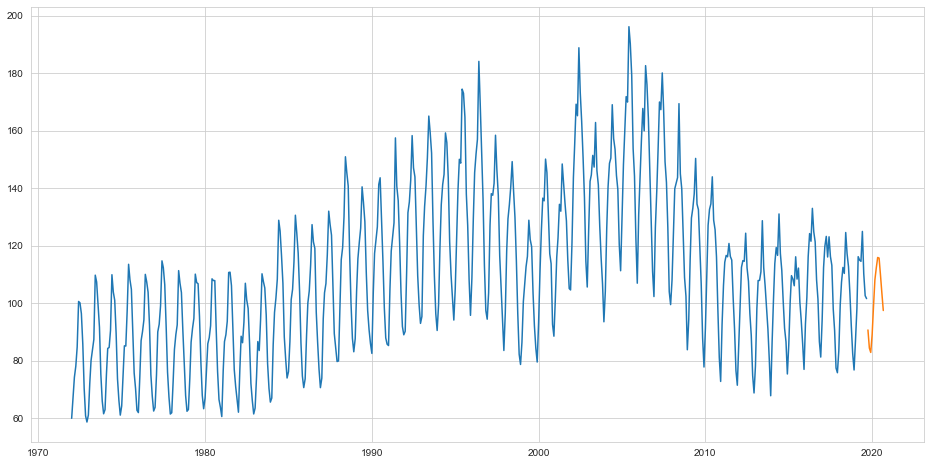

In [112]:
plt.figure(figsize = (16, 8))
plt.plot(df.index, df['Cold_Cycle'])
plt.plot(forecast_df.index, forecast_df['Forecast'])

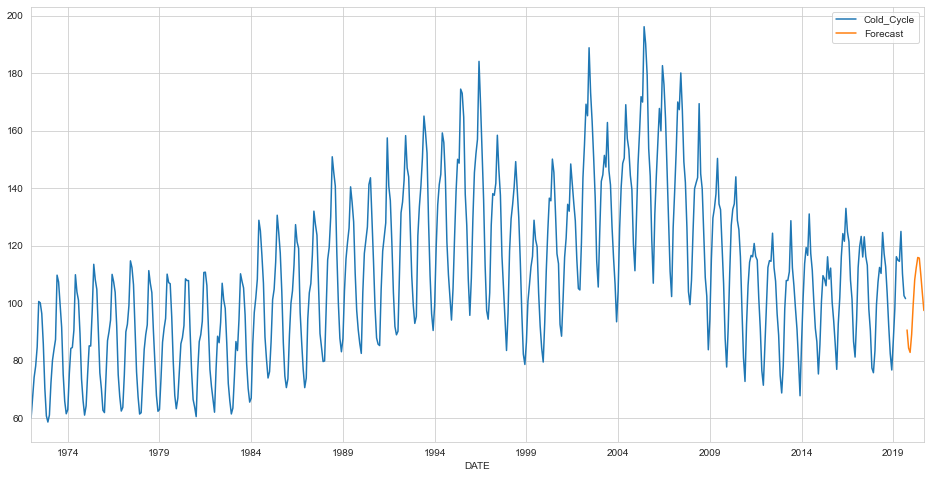

In [113]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8));

(584.0, 608.0)

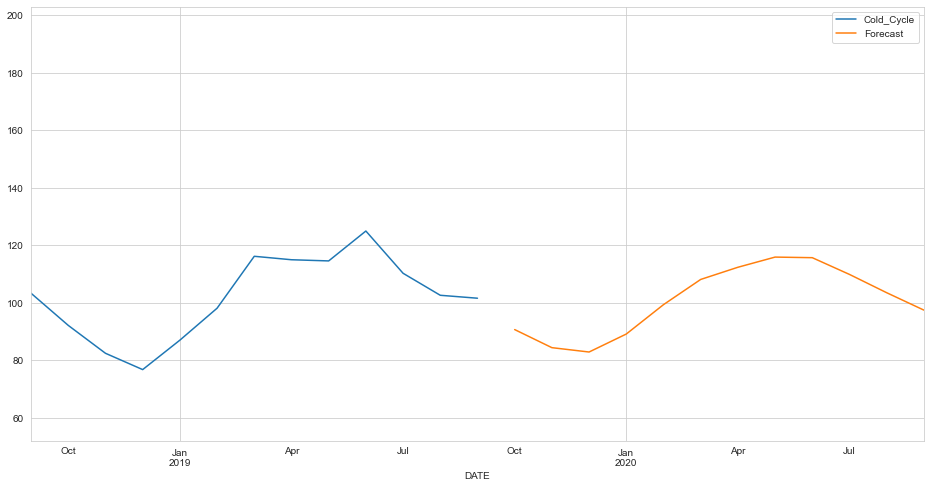

In [114]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8))
plt.xlim('2018-09-01', '2020-09-01')